# nema5 n1 (200 mm LXe) 

- PRODUCED BY NEW SCHEMA, 10^6 events
- Phantom : nema 5
- Events: all
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms
- Time resolution: 50 ps
- qcut > 2 pes
- ntof = 7
- PDE = 0.3
- LXe: 20 mm

In [2]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment in ,,/src

In [3]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [4]:
using Glob
using CSV

In [5]:
using Statistics
using StatsBase
using Printf

In [6]:
using Logging

In [7]:
using ATools

In [8]:
include("../src/ANema.jl") 

Main.ANema

In [9]:
println(names(ATools))

[:ATools, :centers, :dxyz, :edges, :find_max_xy, :fit, :fit_gauss, :fit_gauss_fm, :fit_pol1, :fit_pol2, :fit_pol3, :fit_profile, :fitg1, :fitg2, :fphi, :hist1d, :hist2d, :in_range, :mean_std, :p1df, :phixy, :rxy, :select_by_column_value, :select_by_column_value_closed_interval, :select_by_column_value_closed_left_interval, :select_by_column_value_closed_right_interval, :select_by_column_value_ge, :select_by_column_value_gt, :select_by_column_value_interval, :select_by_column_value_le, :select_by_column_value_lt, :select_by_index, :select_event, :wstd]


In [10]:
println(names(ANema))

[:ANema, :cdoi, :crt, :ctsr, :deltatime, :dftolor, :radial_correcction, :readdf, :selectinterval, :setunits, :write_lors_hdf5, :writemdf]


In [11]:
import Unitful:
    nm, μm, mm, cm, ns, μs, ms, ps, s

In [12]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

## NB functions
- These are specific for plotting and are better kept in the NB

In [13]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

# Notebook

In [14]:
norm = 1.0e+6
dir = "../data/"
dirp = "../plots"
conf = "n5-w-20mm-all-qc2-n1"
out = string(conf, "-mdf")
path = joinpath(dir, conf)
pathp = joinpath(dirp, conf)
patho = joinpath(dir, out)

if isdir(pathp) == false
    mkdir(pathp)
end

if isdir(patho) == false
    mkdir(patho)
end
println("input dir ", path)
println("plots in ", pathp)
println("merged DF in ", patho)

input dir ../data/n5-w-20mm-all-qc2-n1
plots in ../plots/n5-w-20mm-all-qc2-n1
merged DF in ../data/n5-w-20mm-all-qc2-n1-mdf


In [15]:
ndf = ANema.readdf(path)
println("data frame names ", names(ndf))

data frame names ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


In [16]:
println("data frame has length of ", nrow(ndf), " fraction =", nrow(ndf)/norm)

data frame has length of 230979 fraction =0.230979


## q1 vs q2

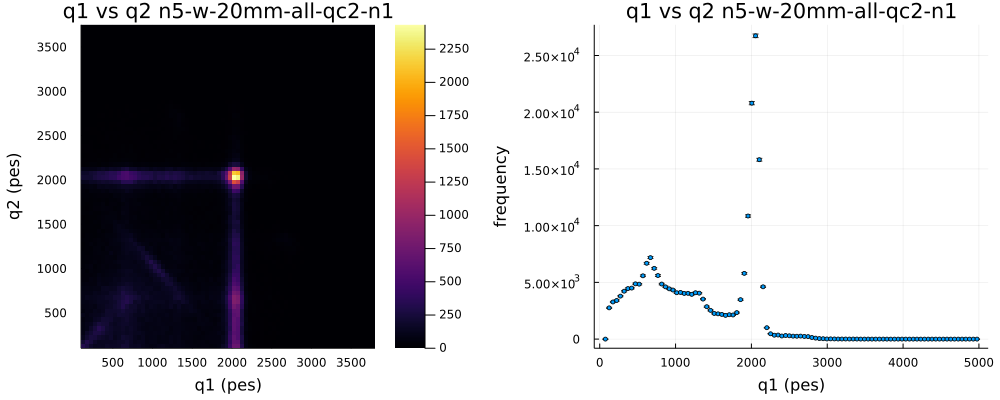

In [17]:
ANema.q1vsq2(ndf, tit="q1 vs q2 $conf", filename=joinpath(pathp, "q1q2"), save=true)

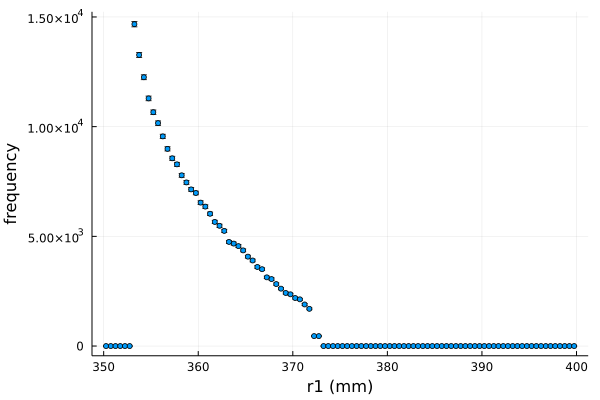

In [18]:
h,p = hist1d(ndf.r1, "r1 (mm)", 100, 350., 400.)
plot(p)

## Cut in (q1,q2) 

In [19]:
wmin = 1900.0
wmax = 2200.0
ndfq =ANema.selectinterval(ndf, "q1", "q2", wmin, wmax);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq), " fraction = ", nrow(ndfq)/norm)

after q1q2 cut: ndfq has a length of 26192 fraction = 0.026192


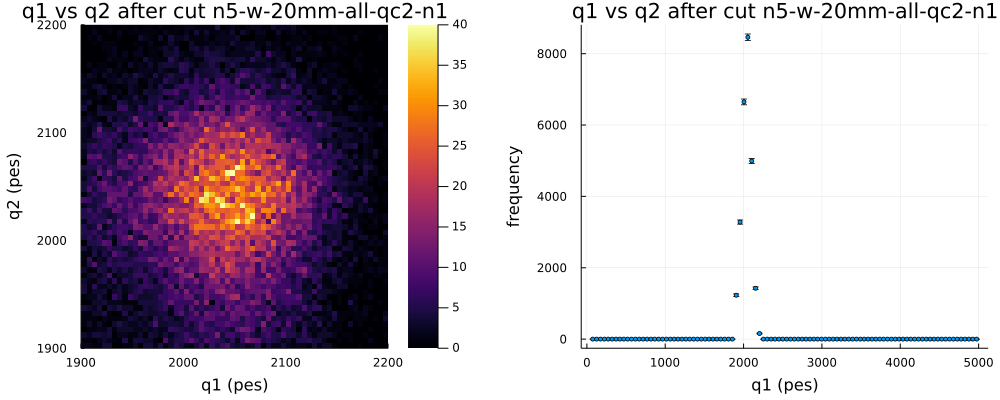

In [20]:
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $conf", 
filename=joinpath(pathp, "q1q2-qcut"), save=true)

## r vs q

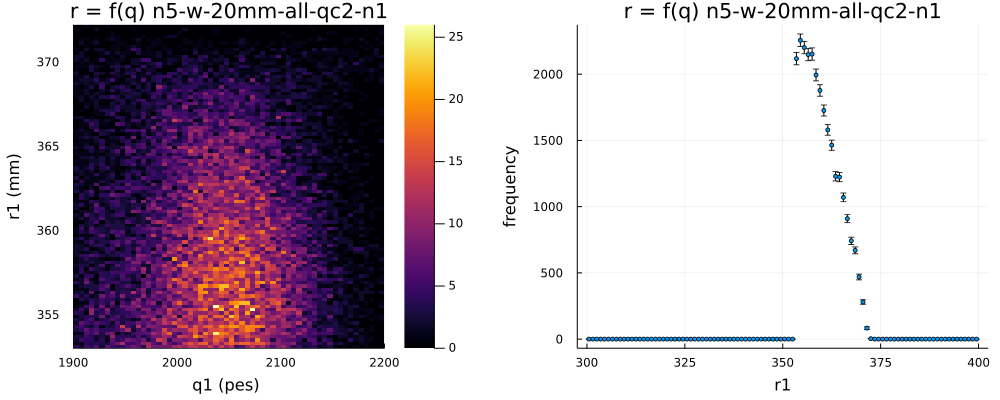

In [21]:
ANema.r1q1(ndfq,tit="r = f(q) $conf", filename=joinpath(pathp, "rq"), save=true)

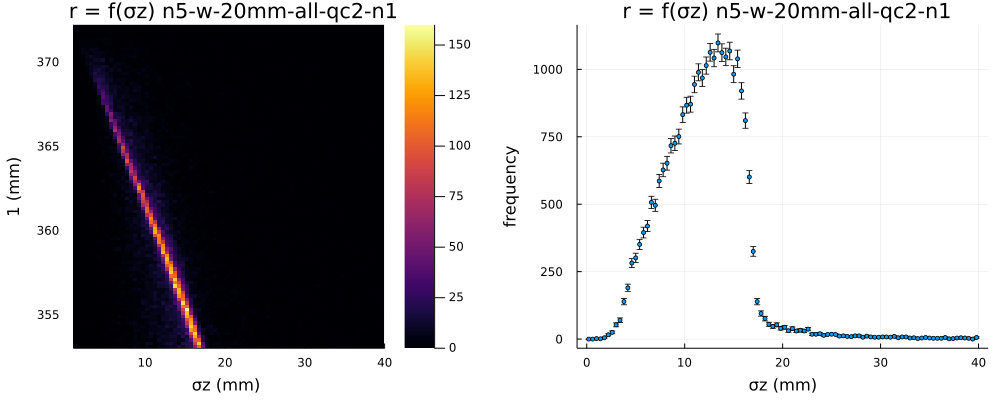

In [22]:
ANema.zstd(ndfq, tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

In [23]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 1.0, 17.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz))

after zstd cut: ndfz has a length of 23849


Fit parameters: a = 373.35 b = -1.26 c = 0.0067 Fit errors: a =  0.09 b = 0.023 c = 0.0013

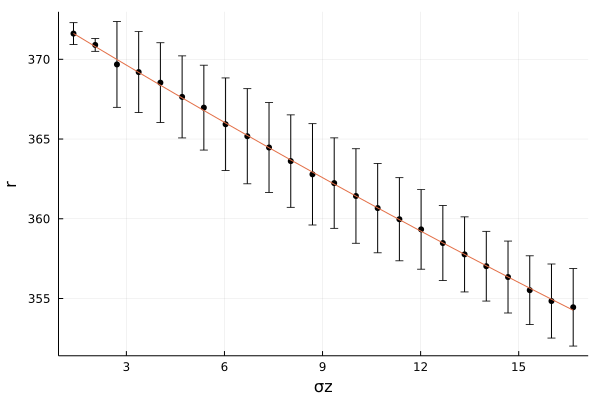

In [24]:
fz2, pz2 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pz2, joinpath(pathp, "zstd-fitpol2"))
plot(pz2)

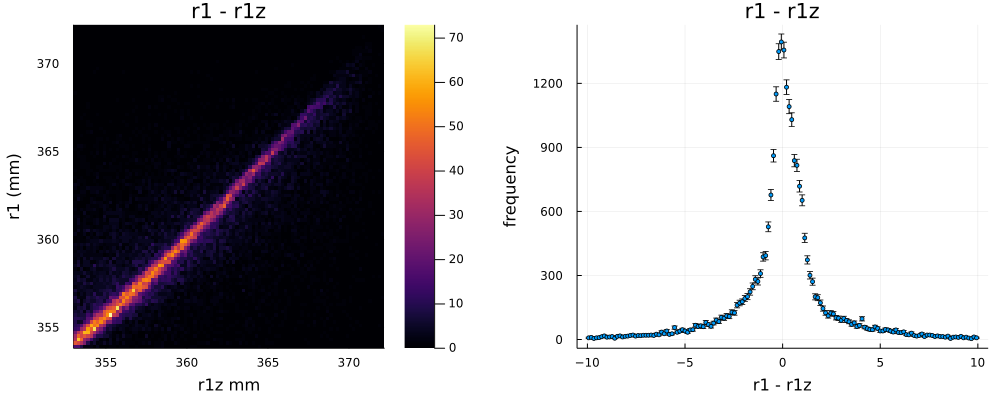

In [25]:
r1z = fz2.g.(ndfz.zstd1) + 0.0 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -10., 10., tit="r1 - r1z", 
         filename=joinpath(pathp, "r1-r1z-zcut"), save=true)


r-rz σ1 =   2.530 σ2 =   0.565

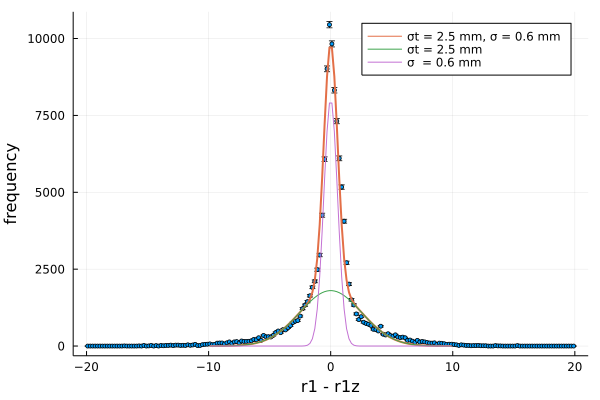

In [26]:
fg, p = fitg2(r1z - ndfz.r1, "r1 - r1z", 200, -20.0, 20.0, 
                      xg1min=-10.0, xg1max=-5.0, 
                      xg2min=-5.0,  xg2max =5.0, 
                      xgmin =-10.0, xgmax  =10.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2"))
plot(p)

Fit parameters: a = 373.35 b = -1.26 c = 0.0067 Fit errors: a =  0.09 b = 0.023 c = 0.0013

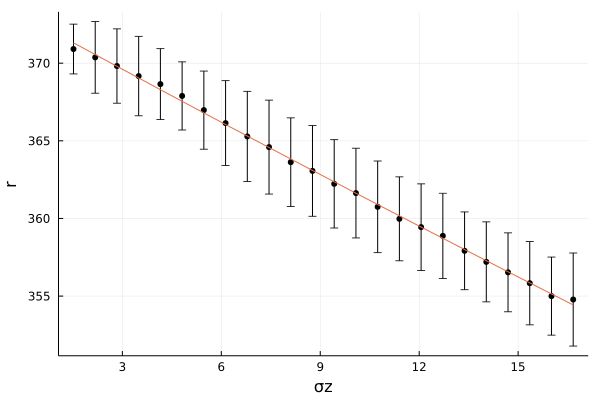

In [27]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

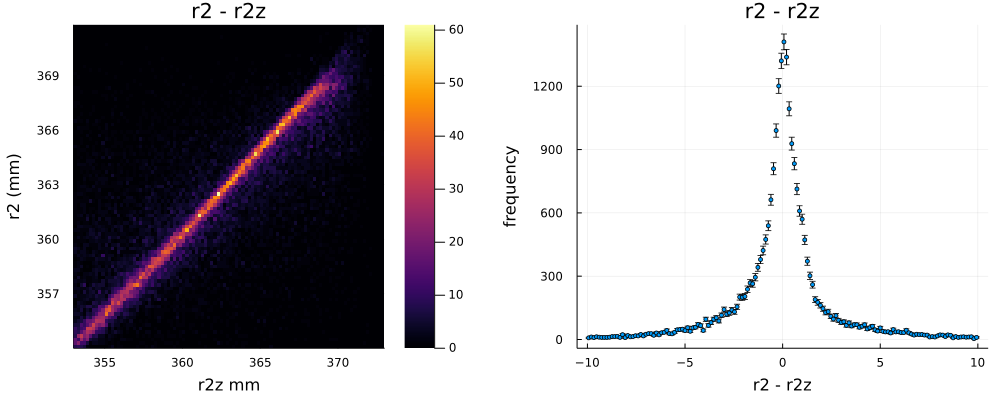

In [28]:
r2z = fzr2.g.(ndfz.zstd2) + 0.0 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -10., 10.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


r-rz σ1 =   2.177 σ2 =   0.504

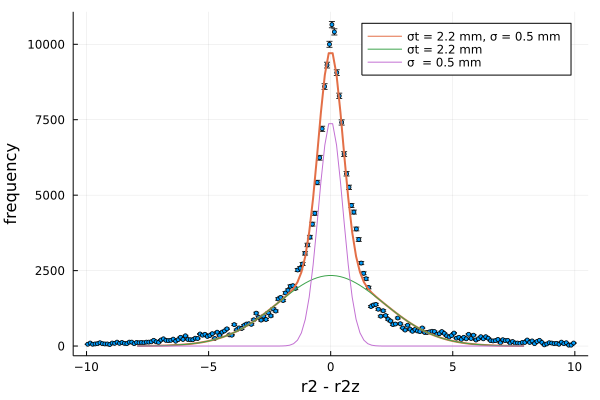

In [29]:
fg, p = fitg2(r2z - ndfz.r2, "r2 - r2z", 200, -10.0, 10.0, 
                      xg1min=-8.0, xg1max=-2.5, 
                      xg2min=-2.5,  xg2max =2.5, 
                      xgmin =-8.0, xgmax  =8.0)
@printf "r-rz σ1 = %7.3f σ2 = %7.3f" fg.std[1] fg.std[2]
ANema.pout(p, joinpath(pathp, "zstd-fitg2-r2"))
plot(p)

## Resolution in (x,y,z,r) intrinsic

 σx =     0.2 mm σy =     0.2 mm σz =     0.4 mm

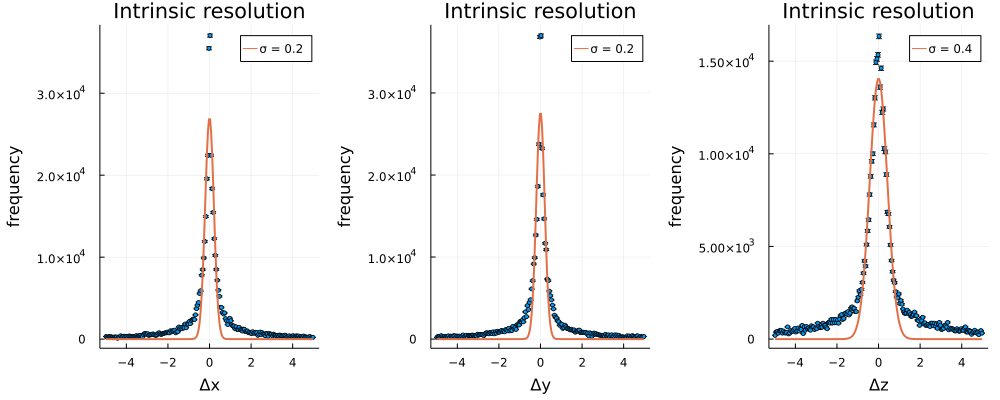

In [30]:
fg,px = fitg1(ndfz.xt1 - ndfz.x1, "Δx", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σx = %7.1f mm" fg.std[1]
fg,py = fitg1(ndfz.yt1 - ndfz.y1, "Δy", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σy = %7.1f mm" fg.std[1]
fg,pz = fitg1(ndfz.zt1 - ndfz.z1, "Δz", 200, -5.0, 5.0, xgmin=-1.5, xgmax=1.5)
@printf " σz = %7.1f mm" fg.std[1]
ANema.plot_and_save(px,py, pz, "Intrinsic resolution", joinpath(pathp, "Intrinsic-res")) 

## Resolución reco

## Position from best estimator (r1p)

In [31]:
xz1,yz1,zz1 = ANema.radial_correction(ndfz.xr1, ndfz.yr1, ndfz.zr1, r1z);
xz2,yz2,zz2 = ANema.radial_correction(ndfz.xr2, ndfz.yr2, ndfz.zr2, r2z);

 σx1 =  0.60 mm σy1 =  0.60 mm σz =  0.43 mm

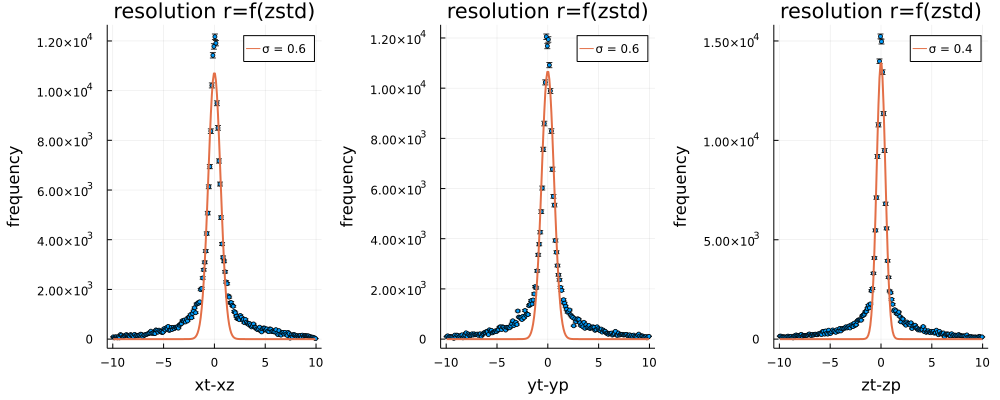

In [32]:
fg,pzx1 = fitg1(ndfz.xt1 - xz1, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy1 = fitg1(ndfz.yt1 - yz1, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz1 = fitg1(ndfz.zt1 - zz1, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx1,pzy1, pzz1, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r1")) 

 σx1 =  0.58 mm σy1 =  0.59 mm σz =  0.39 mm

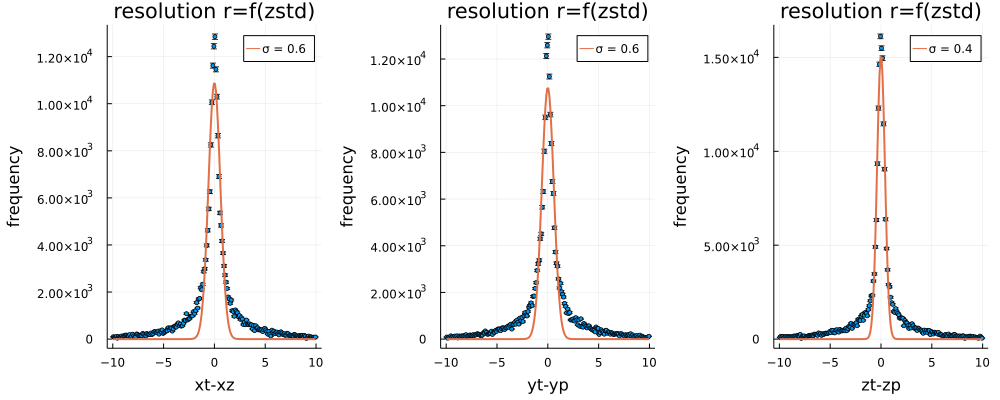

In [33]:
fg,pzx2 = fitg1(ndfz.xt2 - xz2, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy2 = fitg1(ndfz.yt2 - yz2, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz2 = fitg1(ndfz.zt2 - zz2, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx2,pzy2, pzz2, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r2")) 

## Summary: resolution in (X,Y,Z):
- Resolution in Z is very good, not affected by radial corrections.
- Resolution in (X,Y) depends on r estimator resolution, and is much worse for all events.

In [34]:
@printf "typical resolution (FWHM) = %5.2f" 2.3 * fg.std[1]

typical resolution (FWHM) =  0.89

In [35]:
ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

## TOF

In [36]:
dfz = ANema.setunits(ndfz);

In [37]:
println(names(dfz))

["nsipm1", "nsipm2", "phistd1", "phistd2", "zstd1", "zstd2", "q1", "q2", "r1", "r1x", "r2", "r2x", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zt1", "zt2"]


In [38]:
length(names(dfz))

48

First photon, position true: FWHM1 = 226.013 FWHM2 =  28.549

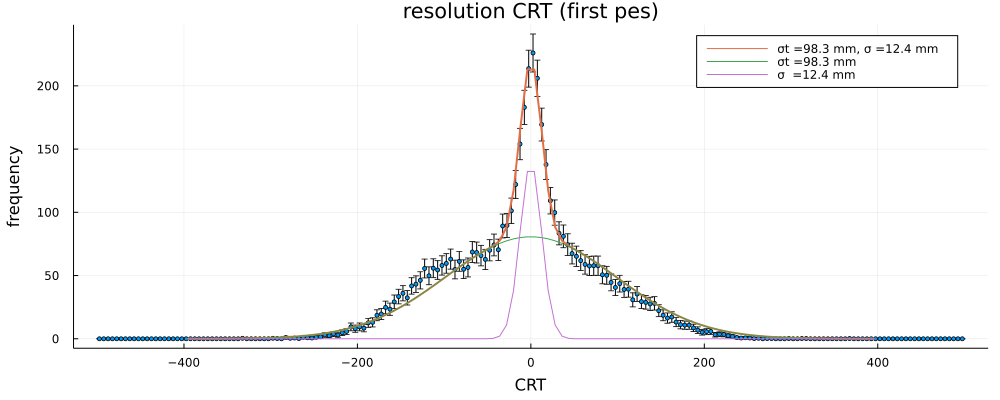

In [39]:
dt = ANema.crt(dfz, ANema.dtfirst, ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(pathp, "CRT-first")) 

fastest photoelectron, position reco: FWHM = 229.200

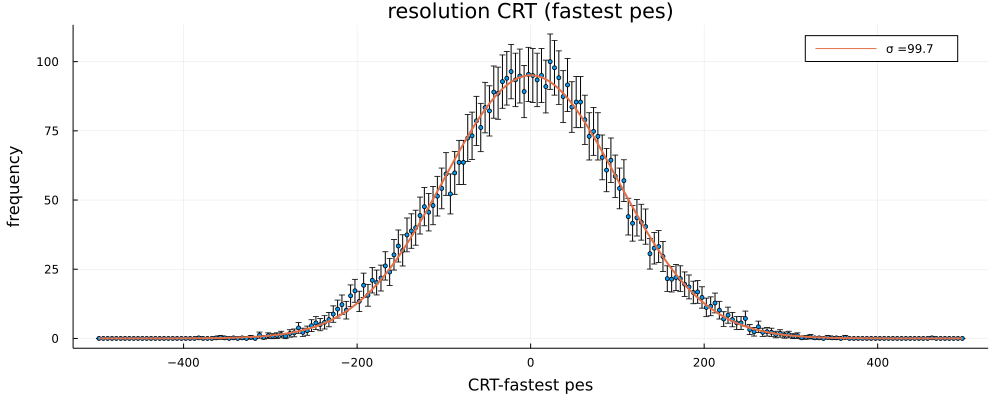

In [40]:
dt = ANema.crt(dfz,  ANema.dtminimum, ANema.postrue)
fg,p = ANema.fitg1(dt.+10.0, "CRT-fastest pes", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 236.886

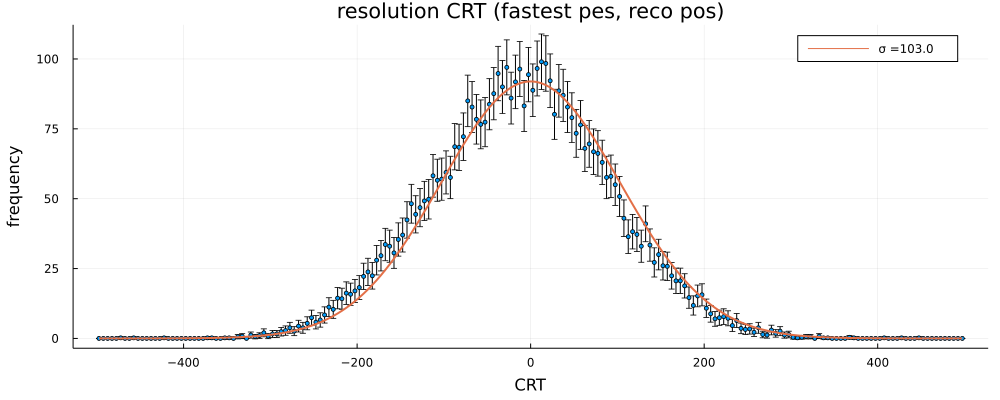

In [41]:
dt = ANema.crt(dfz,  ANema.dtminimum, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes, reco pos)", joinpath(pathp, "CRT-fastest-reco")) 

average photoelectrons, position reco: FWHM = 225.210

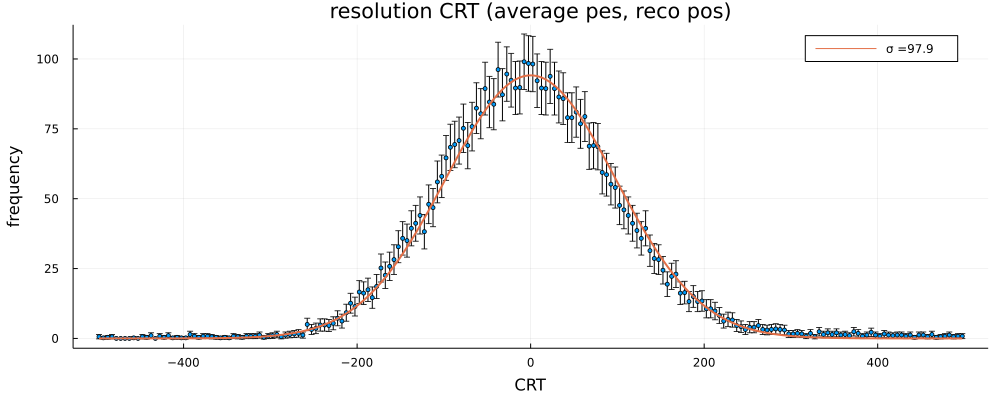

In [42]:
dt = ANema.crt(dfz, ANema.dtaverage, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectrons, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes, reco pos)", joinpath(pathp, "CRT-average-reco")) 

## Save

In [43]:
ANema.writemdf(patho,"mdf-zstd-$conf.csv", ndfz)

"../data/n5-w-20mm-all-qc2-n1-mdf/mdf-zstd-n5-w-20mm-all-qc2-n1.csv"

In [44]:
println("size of data set =", nrow(ndfz), " fraction =", nrow(ndfz)/norm)

size of data set =23849 fraction =0.023849


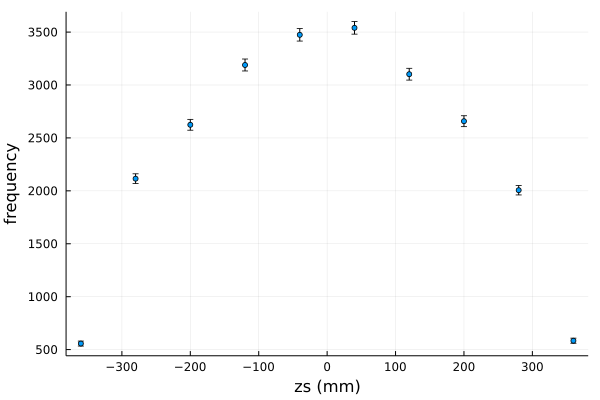

In [45]:
h,p = hist1d(ndfz.zs, "zs (mm)", 10, -400., 400.0, norm=false)
plot(p)

In [46]:
revents = sum(h.weights)
println("events recorded in z bins =", h.weights)
println("sensitivity per bin =", h.weights/norm)
println("sensitivity  (%) =", 100 * revents/norm)


events recorded in z bins =[557, 2115, 2624, 3189, 3474, 3540, 3102, 2658, 2006, 584]
sensitivity per bin =[0.000557, 0.002115, 0.002624, 0.003189, 0.003474, 0.00354, 0.003102, 0.002658, 0.002006, 0.000584]
sensitivity  (%) =2.3849


In [47]:
hs = h.weights / norm
he = 0.003 * hs;

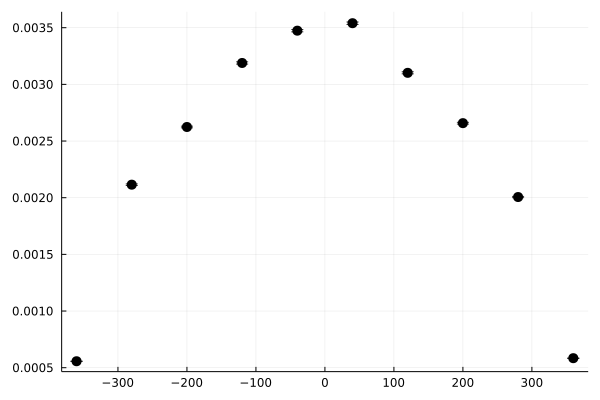

In [48]:
p1 = scatter(centers(h),hs, yerror=he,
	          shape = :circle, markersize=6, color = :black, legend=false, fmt = :png)

In [49]:
r = 70.0
L = 100.0
S = 2*π*r*L
asipm = 6*6
nsipm = S/asipm
@printf "number of SiPMs = %5.0f" nsipm

number of SiPMs =  1222